In [1]:
#imports too many libraries and the data

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression 
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.optimize import minimize
import scipy.stats as stats


train_size = 0.9

data = pd.read_excel('./data/example_failure_data_sets.xlsx', sheet_name="SYS1")

train_x = data["FT"].to_numpy()[0:int(len(data["FT"])*train_size)]
train_y = data["FN"].to_numpy()[0:int(len(data["FN"])*train_size)]

In [6]:
#methods needed for MLE

def exponential(x, a, b):
    return a*(1-np.exp(-b*x))

#can weight the points if you want but is unweighted by default.
def MLERegression(params):
    a, b, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = exponential(train_x, a, b)
    
    negLL = -np.sum(stats.norm.logpdf(train_y[:-5], loc=yhat[:-5], scale=sd) )# , scale=sd return negative LL\
    negLL += -np.sum(stats.norm.logpdf(train_y[-5:], loc=yhat[-5:], scale=sd) )

    return(negLL)

In [7]:
params = [130, 0.0001, 1]
results = minimize(MLERegression, params, method = "Nelder-Mead", options={"disp": True, "maxiter": 200}) #

print(results)

Optimization terminated successfully.
         Current function value: 356.811969
         Iterations: 113
         Function evaluations: 203
 final_simplex: (array([[1.13944533e+02, 6.08551787e-05, 4.50752123e+00],
       [1.13944527e+02, 6.08551355e-05, 4.50751148e+00],
       [1.13944631e+02, 6.08550508e-05, 4.50752890e+00],
       [1.13944530e+02, 6.08550744e-05, 4.50753823e+00]]), array([356.81196948, 356.81196948, 356.81196948, 356.81196948]))
           fun: 356.81196947770184
       message: 'Optimization terminated successfully.'
          nfev: 203
           nit: 113
        status: 0
       success: True
             x: array([1.13944533e+02, 6.08551787e-05, 4.50752123e+00])


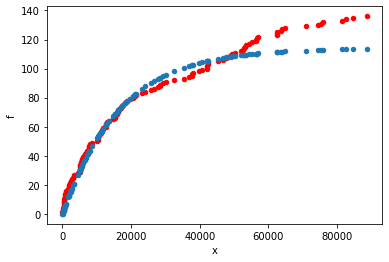

In [8]:
plt = data.plot.scatter(x='FT', y='FN', c="red")

f = [exponential(x, results.x[0], results.x[1]) for x in data["FT"].to_numpy()]

df = pd.DataFrame()
df['f'] = f
df['x'] = data["FT"].to_numpy()
df.plot.scatter(x='x', y='f', ax=plt)

(array([1.44426010e+02, 3.20869088e-05]), array([[ 3.97959785e-04, -2.46707780e-10],
       [-2.46707780e-10,  1.53847040e-16]]))


/home/swpshadow/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


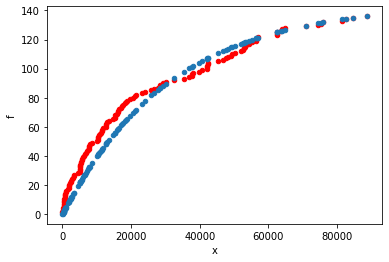

In [11]:
#weighted curve fit which uses least squares. Not a mathematically good method but easy and fast to implement

w = [ 1- i for i in np.linspace(0.8,1, len(train_x) + 2)]
p = curve_fit(exponential, train_x, train_y, sigma=w[1:-1], absolute_sigma=True)
print(p)

plt = data.plot.scatter(x='FT', y='FN', c="red")
f = [exponential(x, p[0][0], p[0][1]) for x in data["FT"].to_numpy()]

df = pd.DataFrame()
df['f'] = f
df['x'] = data["FT"].to_numpy()
df.plot.scatter(x='x', y='f', ax=plt)

In [19]:
#tensorflow network. 

mod = tf.keras.Sequential([
    layers.Dense(1),
     layers.Dense(10,  activation='relu'),
    layers.Dense(10, activation='elu'),
    layers.Dense(1)
])
mod.compile(optimizer=tf.optimizers.Adamax(learning_rate=0.01),loss='mean_absolute_error')

mod.fit(train_x, train_y, epochs=10000, batch_size=(len(train_x)), verbose=0)

0.9952615396038469
0.367914443816296
      predicted    y      x
122  124.110466  123  62551
123  124.214760  124  62651
124  124.225174  125  62661
125  125.342110  126  63732
126  125.729050  127  64103
127  126.552902  128  64893
128  132.966705  129  71043
129  136.430145  130  74364
130  137.519974  131  75409
131  138.195755  132  76057
132  143.916000  133  81542
133  145.125778  134  82702
134  147.069717  135  84566
135  151.362289  136  88682


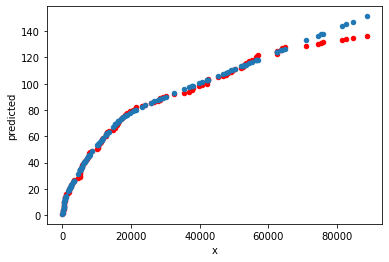

In [20]:
#results for NN

NNres = pd.DataFrame()

NNres['predicted']= [num[0] for num in mod.predict(data["FT"])]

NNres['y'] = data["FN"]
NNres['x'] = data['FT']

print(metrics.r2_score(NNres['predicted'], data['FN']))

print(metrics.r2_score(NNres['predicted'][len(train_x):], data['FN'][len(train_x):]))

print(NNres[len(train_x):])

plt = NNres.plot.scatter(x='x', y='y', c='red')
NNres.plot.scatter(x='x', y='predicted', ax=plt)